Replicate paper

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
class SpotRateModel:
    def __init__(self,
                 r0,
                 a,
                 b,
                 theta,
                 sigma,
                 lamda,
                 gamma,
                 mu,
                 h,
                 t,
                 T,
                 m,
                 model_name, 
                 mc_type):
        self.r0 = r0
        self.a = a
        self.b = b
        self.theta = theta
        self.sigma = sigma
        self.lamda = lamda
        self.gamma = gamma
        self.mu = mu
        self.h = h
        self.t = t
        self.T = T
        self.m = m
        self.delta_t = 1/m
        self.model_name = model_name
        self.mc_type = mc_type
        
            
    def _get_t_step(self, 
                    prev_spot_rate):
        if self.model_name == "vasicek":
            t_step = (self.theta - self.a*prev_spot_rate - self.lamda*self.sigma)*self.delta_t
        if self.model_name == "cir":
            t_step = (self.theta - self.a*prev_spot_rate - self.lamda*self.sigma*np.sqrt(prev_spot_rate))*self.delta_t
        return t_step
    
    def _get_stoch_step(self, 
                        prev_spot_rate, 
                        stoch_norm):
        if self.model_name == "vasicek":
            stoch_step = self.sigma*stoch_norm*np.sqrt(self.delta_t)
        if self.model_name == "cir":
            stoch_step = self.sigma*np.sqrt(prev_spot_rate)*stoch_norm*np.sqrt(self.delta_t)
        return stoch_step
    
    def _get_jump_step(self, 
                       jump_norm, 
                       jump_pois):
        return jump_norm*jump_pois
      
    def _get_jump_norm(self, 
                       prev_spot_rate, 
                       stoch_norm, 
                       jump_pois):
        
        if jump_pois == 0:
            return 0
        t_step = self._get_t_step(prev_spot_rate)
        stoch_step = self._get_stoch_step(prev_spot_rate, stoch_norm)
        
        lower_bound = (-prev_spot_rate - t_step - stoch_step)/jump_pois
        upper_bound = -lower_bound
        return truncnorm(lower_bound, upper_bound, loc=self.mu, scale=self.gamma).rvs(1)[0]
    

    def get_next_steps(self, 
                       prev_spot_rate):
        
        if self.model_name == "vasicek":
            stoch_norm = np.random.normal()
            jump_norm = np.random.normal(self.mu, self.gamma)
            jump_pois = np.random.poisson(self.h*self.delta_t)
            
            t_step = self._get_t_step(prev_spot_rate)
            stoch_step = self._get_stoch_step(prev_spot_rate, stoch_norm)
            jump_step = self._get_jump_step(jump_norm, jump_pois)
            
        elif self.model_name == "cir":    
            stoch_norm = np.random.normal()
            jump_pois = np.random.poisson(self.h*self.delta_t)
        
            t_step = self._get_t_step(prev_spot_rate)
            stoch_step = self._get_stoch_step(prev_spot_rate, stoch_norm)
            
            jump_norm = self._get_jump_norm(prev_spot_rate, stoch_norm, jump_pois)
            
            jump_step = self._get_jump_step(jump_norm, jump_pois)
                        
        return t_step, stoch_step, jump_step, stoch_norm, jump_norm, jump_pois
                      
    def get_next_step_for_antithetic(self,
                                     prev_spot_rate, 
                                     stoch_norm, 
                                     jump_norm, 
                                     jump_pois):
        
        t_step = self._get_t_step(prev_spot_rate)
        stoch_step = self._get_stoch_step(prev_spot_rate, stoch_norm)
        jump_step = self._get_jump_step(jump_norm, jump_pois)
        
        return t_step, stoch_step, jump_step
            
            
    def get_spot_rates(self):
        prev_spot_rate = self.r0
        self.spot_rates = []
        self.antithetic_rates = []
        
        for i in range(self.m*(self.T-self.t)):
                if i==0:
                    self.spot_rates.append(prev_spot_rate)
                    if self.mc_type=="antithetic":
                        self.antithetic_rates.append(prev_spot_rate)
                else:
                    prev_spot_rate = self.spot_rates[i-1]
                    t_step, stoch_step, jump_step, stoch_norm, jump_norm, jump_pois = self.get_next_steps(prev_spot_rate)
                    spot_rate = prev_spot_rate + t_step + stoch_step + jump_step
                    self.spot_rates.append(spot_rate)
                    if self.mc_type=="antithetic":
                        prev_spot_rate = self.antithetic_rates[i-1]
                        if self.model_name == "cir":
                            jump_norm_a = self._get_jump_norm(prev_spot_rate, -stoch_norm, jump_pois)
                            if jump_norm*jump_norm_a > 0:
                                jump_norm_a = -jump_norm_a
                            t_step, stoch_step, jump_step = self.get_next_step_for_antithetic(prev_spot_rate, -stoch_norm, jump_norm_a, jump_pois)
                        if self.model_name == "vasicek":
                            t_step, stoch_step, jump_step = self.get_next_step_for_antithetic(prev_spot_rate, -stoch_norm, -jump_norm, jump_pois)
                        spot_rate = prev_spot_rate + t_step + stoch_step + jump_step
                        self.antithetic_rates.append(spot_rate)
            
        return pd.DataFrame(self.spot_rates, index=np.arange(self.m*(self.T-self.t))), pd.DataFrame(self.antithetic_rates, index=np.arange(self.m*(self.T-self.t)))
            

            

In [8]:
class MonteCarloSimulation:
    def __init__(self, 
                 num_simulations,
                 spot_rate_model):
        self.num_simulations = num_simulations
        self.spot_rate_model = spot_rate_model

    def simulate(self):
        
        spot_rates = pd.DataFrame(index=np.arange((self.spot_rate_model.T-self.spot_rate_model.t)*self.spot_rate_model.m))
        antithetic_rates = pd.DataFrame(index=np.arange((self.spot_rate_model.T-self.spot_rate_model.t)*self.spot_rate_model.m))
        spot_rates_cumsum = pd.DataFrame(index=np.arange(self.spot_rate_model.T-self.spot_rate_model.t))
        spot_rates_cumsum_a = pd.DataFrame(index=np.arange(self.spot_rate_model.T-self.spot_rate_model.t))

        
        for i in range(self.num_simulations):
            spot_rates[i], temp = self.spot_rate_model.get_spot_rates()
            if temp.empty:
                antithetic_rates[i], temp = self.spot_rate_model.get_spot_rates()
            else:
                antithetic_rates[i] = temp
            df = pd.DataFrame(np.reshape(spot_rates[i].values, (self.spot_rate_model.m, self.spot_rate_model.T-self.spot_rate_model.t)))
            df_a = pd.DataFrame(np.reshape(antithetic_rates[i].values, (self.spot_rate_model.m, self.spot_rate_model.T-self.spot_rate_model.t)))
            
            spot_rates_cumsum[i] = df.sum().cumsum().values
            spot_rates_cumsum_a[i] = df_a.sum().cumsum().values
        
        bond_prices = spot_rates_cumsum.copy()
        bond_prices_a = spot_rates_cumsum_a.copy()
        for i in range(self.num_simulations):
            bond_prices[i] = np.exp(-bond_prices[i]*self.spot_rate_model.delta_t)
            bond_prices_a[i] = np.exp(-bond_prices_a[i]*self.spot_rate_model.delta_t)

            
        bond_prices_all = pd.merge(bond_prices, bond_prices_a, left_index=True, right_index=True)

        bond_prices = bond_prices.mean(axis=1)
        bond_prices_a = bond_prices_a.mean(axis=1)
        
        bond_prices = pd.concat([pd.Series([1.0]), bond_prices], ignore_index=True)
        bond_prices_a = pd.concat([pd.Series([1.0]), bond_prices_a], ignore_index=True)
            

        return spot_rates, bond_prices, antithetic_rates, bond_prices_a, bond_prices_all
    

In [9]:
vasicek = SpotRateModel(r0=0.05,
                 a=0.5,
                 b=0.05,
                 theta=0.025,
                 sigma=0.08,
                 lamda=-0.5,
                 gamma=0.01,
                 mu=0,
                 h=10,
                 t=0,
                 T=20,
                 m=365,
                 model_name='vasicek',
                mc_type="antithetic")

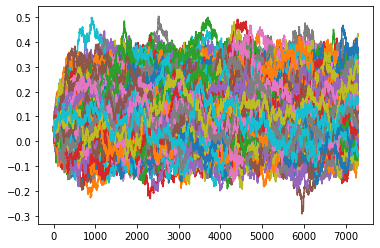

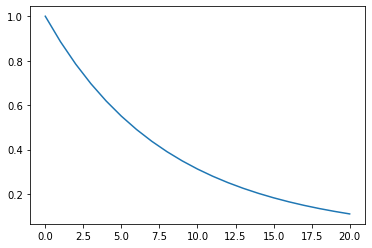

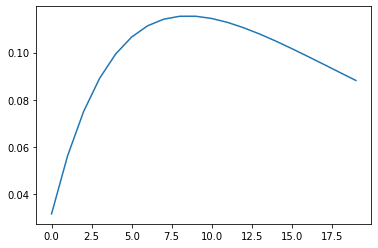

In [10]:
mc_vasicek = MonteCarloSimulation(1000, vasicek)
sr_vasicek, bp_vasicek, sr_vasicek_a, bp_vasicek_a, bond_prices_all_a = mc_vasicek.simulate()
sr_vasicek.plot(legend=False)
plt.show()
bp_vasicek.plot()
plt.show()
bond_prices_all_a.std(axis=1).plot()
plt.show()

In [11]:
vasicek = SpotRateModel(r0=0.05,
                 a=0.5,
                 b=0.05,
                 theta=0.025,
                 sigma=0.08,
                 lamda=-0.5,
                 gamma=0.01,
                 mu=0,
                 h=10,
                 t=0,
                 T=20,
                 m=365,
                 model_name='vasicek',
                mc_type="vanilla")

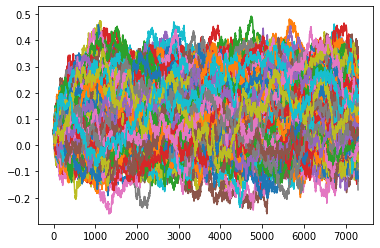

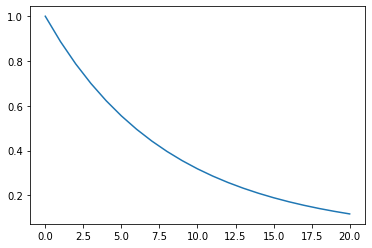

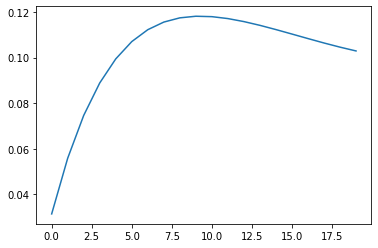

In [12]:
mc_vasicek = MonteCarloSimulation(1000, vasicek)
sr_vasicek, bp_vasicek, sr_vasicek_a, bp_vasicek_a, bond_prices_all_v = mc_vasicek.simulate()
sr_vasicek.plot(legend=False)
plt.show()
bp_vasicek.plot()
plt.show()
bond_prices_all_v.std(axis=1).plot()
plt.show()

In [13]:
std = pd.DataFrame(bond_prices_all_a.std(axis=1), columns={'ANTITHETIC'})
std['VANILLA'] = bond_prices_all_v.std(axis=1)

<AxesSubplot:title={'center':'Standard Deviation - VASICEK'}>

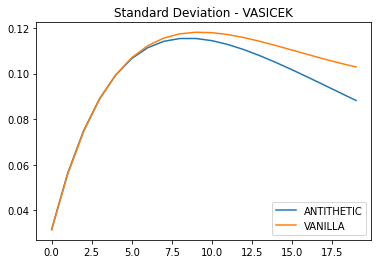

In [14]:
std.plot(legend=True, title='Standard Deviation - VASICEK')

In [15]:
cir = SpotRateModel(r0=0.05,
                 a=0.5,
                 b=0.05,
                 theta=0.025,
                 sigma=0.08,
                 lamda=-0.5,
                 gamma=0.01,
                 mu=0,
                 h=10,
                 t=0,
                 T=20,
                 m=365,
                 model_name='cir', 
                mc_type='antithetic')

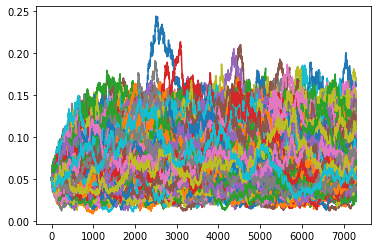

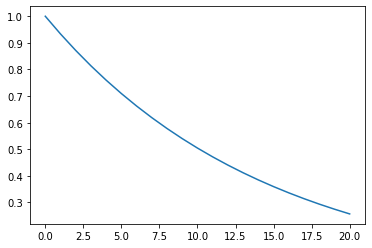

In [16]:
mc_cir = MonteCarloSimulation(1000, cir)
sr_cir, bp_cir, sr_cir_a, bp_cir_a, bp_a = mc_cir.simulate()
sr_cir.plot(legend=False)
plt.show()
bp_cir.plot()
plt.show()

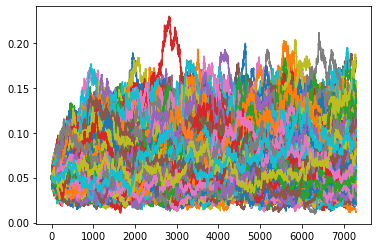

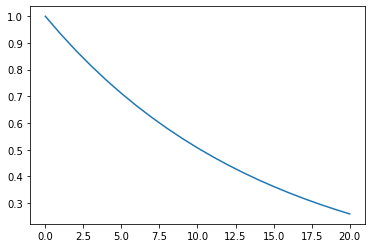

In [17]:
cir = SpotRateModel(r0=0.05,
                 a=0.5,
                 b=0.05,
                 theta=0.025,
                 sigma=0.08,
                 lamda=-0.5,
                 gamma=0.01,
                 mu=0,
                 h=10,
                 t=0,
                 T=20,
                 m=365,
                 model_name='cir', 
                mc_type='vanilla')
mc_cir = MonteCarloSimulation(1000, cir)
sr_cir, bp_cir, sr_cir_a, bp_cir_a, bp_v = mc_cir.simulate()
sr_cir.plot(legend=False)
plt.show()
bp_cir.plot()
plt.show()

<AxesSubplot:title={'center':'Standard Deviation - CIR'}>

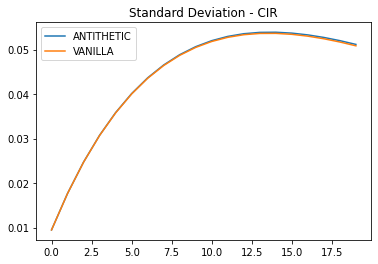

In [25]:
std = pd.DataFrame(bp_a.std(axis=1), columns={'ANTITHETIC'})
std['VANILLA'] = bp_v.std(axis=1)
std.plot(legend=True, title='Standard Deviation - CIR')

In [26]:
bp = pd.DataFrame(index=np.arange(1, 21))
bp['CIR'] = bp_cir
bp['VASICEK'] = bp_vasicek

<AxesSubplot:>

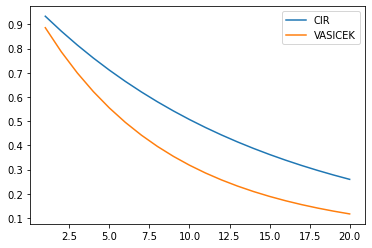

In [27]:
bp.plot(legend=True)